In [70]:
# Copyright Tay Zhi Cong, year 2025

import numpy as np 
import matplotlib.pyplot as plt 
from scipy import signal 
import math

#### Appendix: Method to obtain low pass filter tap coeffiecients

In [9]:
def get_low_pass_filter_tap_coeffiecients_using_kaiser_window_design(stop_band_attenuation, f_sampling, f_transition, f_minus_6db, filter_length):
    beta = signal.kaiser_beta(stop_band_attenuation) # 1. calculate the kaiser beta
    # filter_length = math.ceil((f_sampling/f_transition) * (stop_band_attenuation-8)/14) # 2. estimate the filter length : N ~= f_sampling/ f_transition * (Attenuation (in dB) - 8) / 14
    filter_tap = signal.windows.kaiser(filter_length, beta=beta)
    h = np.sinc(2*f_minus_6db/f_sampling*np.linspace(-(filter_length - 1)/2,(filter_length - 1)/2,filter_length))*filter_tap
    h = h/sum(h)
    return h

def plot_filter_to_verify_spec(h, num_fft, f_sampling):
    freq_response = np.fft.fft(h, num_fft)
    freq = np.arange(0, len(freq_response), 1)/len(freq_response) * f_sampling

    plt.figure()
    ax = plt.subplot(1,2,1)
    plt.plot(freq, 20 * np.log10(abs(freq_response)), 'C0')
    plt.grid(which="major")
    plt.grid(which="minor")
    plt.minorticks_on()
    ax.set_xlim(0, 50)
    ax.set_ylim(-80, 1)
    
    ax = plt.subplot(2,2,2)
    plt.plot(freq, 20 * np.log10(abs(freq_response)), 'C0')
    plt.grid(which="major")
    plt.grid(which="minor")
    plt.minorticks_on()
    
    # Define the desired zoom region
    x_min, x_max = 0, 15
    y_min, y_max = -0.1, 0.1
    
    # Set the x and y limits of the axes to zoom to the rectangle
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    
    ax = plt.subplot(2,2,4)
    plt.plot(freq, 20 * np.log10(abs(freq_response)), 'C0')
    plt.grid(which="major")
    plt.grid(which="minor")
    plt.minorticks_on()
    
    # Define the desired zoom region
    x_min, x_max = 11, 22
    y_min, y_max = -80, -60
    
    # Set the x and y limits of the axes to zoom to the rectangle
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)


#### Designing a five path polyphase downsampling filter with the following spec:

Input sample rate: 100kHz \
Output sample rate: 20kHz \
Pass band: 0 - 8kHz \
Stop band: 12 - 50kHz \
In-band ripple: 0.1dB \
Stop-band attennuation: 60dB


#### Step 1: Get the filter taps coefficients that meet the spec

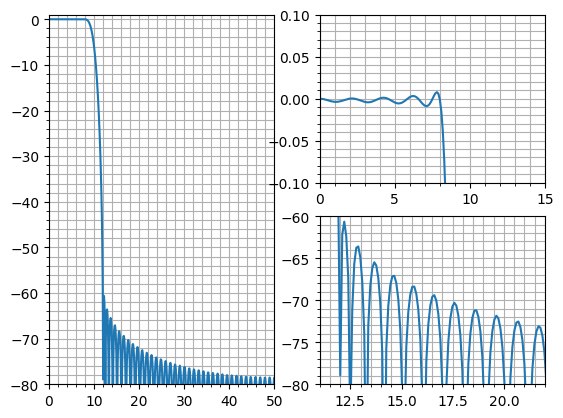

In [10]:
stop_band_attenuation = 60
f_sampling = 100
f_transition = 4
f_minus_6db = 10
low_pass_filter_length = 95 # use 93
num_fft = 1024

h = get_low_pass_filter_tap_coeffiecients_using_kaiser_window_design(stop_band_attenuation, f_sampling, f_transition, f_minus_6db, filter_length)
plot_filter_to_verify_spec(h, num_fft, f_sampling)


#### Step 2: Partition the filter tap coefficients to form a five-path polyphase filter

In [12]:
h_partitioned = np.reshape(h, (19, 5))

#### Step 3(a): Partition the input signal into five-path to simulate the downsampling and commutating the input signal into the five-path polyphase filter

Try to input signal x1_orig into the filter, and we should see an attenuation as its frequency is at 21kHz.

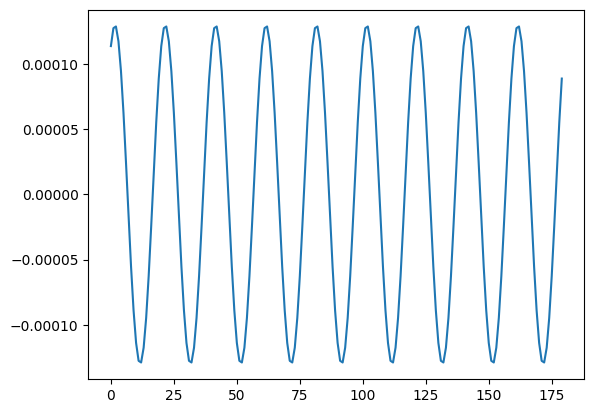

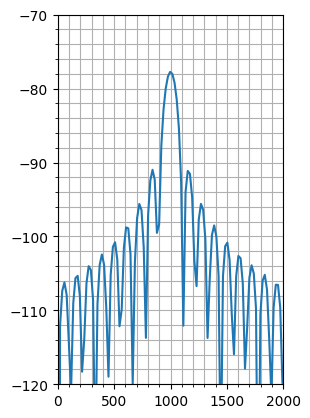

In [72]:
n = np.arange(0, 1000, 1)
x1_orig = np.exp(1j*2*np.pi*n*21/100);
x1 = np.reshape(x1_orig, (200,5))

first_path_result = np.convolve(x1[:,4], h_partitioned[:,0])
second_path_result = np.convolve(x1[:,3], h_partitioned[:,1])
third_path_result = np.convolve(x1[:,2], h_partitioned[:,2])
forth_path_result = np.convolve(x1[:,1], h_partitioned[:,3])
fifth_path_result = np.convolve(x1[:,0], h_partitioned[:,4])
out = first_path_result+second_path_result+third_path_result+forth_path_result+fifth_path_result

# each path will have length 200 + 19 - 1 = 218
# discard the first 19 and last 19 result
out_after_discard = out[19:-19]

plt.figure()
plt.plot(out_after_discard)
plt.figure()
ax = plt.subplot(1,2,2)
ff = np.arange(0, 1, 1/1024) * 20000
out_fft = 1/len(out_after_discard) * np.fft.fft(out_after_discard, 1024) #* np.hanning(1024) # windowed fft
plt.plot(ff, 20*np.log10(np.abs(out_fft)))
plt.grid(which="major")
plt.grid(which="minor")
plt.minorticks_on()
plt.ylim((-120,-70))
plt.xlim((0,2000))
plt.grid(True)


#### Step 3(b): Partition the input signal into five-path to simulate the downsampling and commutating the input signal into the five-path polyphase filter

Try to input signal x2_orig into the filter, and we should see no attenuation as its frequency is at 1.5kHz.

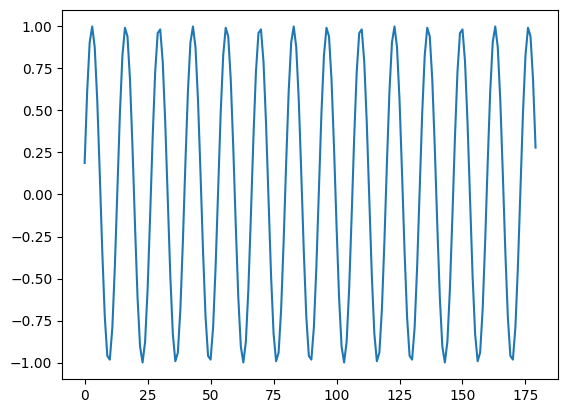

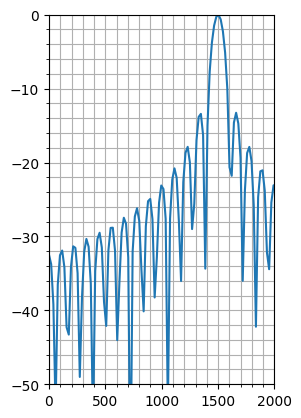

In [69]:
n = np.arange(0, 1000, 1)
x2_orig = x1_orig + np.exp(1j*2*np.pi*n*1.5/100);
x2 = np.reshape(x2_orig, (200,5))

first_path_result = np.convolve(x2[:,4], h_partitioned[:,0])
second_path_result = np.convolve(x2[:,3], h_partitioned[:,1])
third_path_result = np.convolve(x2[:,2], h_partitioned[:,2])
forth_path_result = np.convolve(x2[:,1], h_partitioned[:,3])
fifth_path_result = np.convolve(x2[:,0], h_partitioned[:,4])
out = first_path_result+second_path_result+third_path_result+forth_path_result+fifth_path_result

# each path will have length 200 + 19 - 1 = 218
# discard the first 19 and last 19 result
out_after_discard = out[19:-19]

plt.figure()
plt.plot(out_after_discard)
plt.figure()
ax = plt.subplot(1,2,2)
#plt.ylim((-120,-70))
ff = np.arange(0, 1, 1/1024) * 20000
out_fft = 1/len(out_after_discard) * np.fft.fft(out_after_discard, 1024) #* np.hanning(1024) # windowed fft
plt.plot(ff, 20*np.log10(np.abs(out_fft)))
plt.grid(which="major")
plt.grid(which="minor")
plt.minorticks_on()
plt.ylim((-50,0))
plt.xlim((0,2000))
plt.grid(True)